This notebook just tests all the functions in bw_lcow_functions.
It also includes some old treatment lcow calculating functions

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp
import os
import math
from shapely.geometry import MultiPoint, Point, Polygon
from sklearn.cluster import DBSCAN

import haversine as hs
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing
from IPython.display import clear_output
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
from watertap3.utils.post_processing import get_results_table
from bw_lcow_functions import *
import matplotlib.colors as mcolors

In [4]:
state_alpha = 'KS'
bw_cluster_kmeans = create_cluster_id_df(state_alpha)
bw_cluster_kmeans.head(5)

[0]
[0 1 2]
[0 1 2 3]


,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,cluster_id,centers
0,KS,NURE-OR205137,37.879,-98.547,Stafford,89.0,0.094635,0.775108,0.0735,0.038430,0,"[37.47421739130435, -98.11617391304348]"
1,KS,NURE-OR207509,37.681,-97.309,Sedgwick,30.0,0.063090,1.291759,0.0735,0.034930,0,"[37.47421739130435, -98.11617391304348]"
2,KS,NURE-OR207510,37.694,-97.359,Sedgwick,36.0,0.031545,0.809551,0.0735,0.036839,0,"[37.47421739130435, -98.11617391304348]"
3,KS,NURE-OR207527,37.523,-97.287,Sedgwick,39.0,0.131165,0.719998,0.0735,0.033544,0,"[37.47421739130435, -98.11617391304348]"
4,KS,NURE-OR207852,37.053,-97.050,Cowley,39.0,0.012618,1.153985,0.0735,0.039726,0,"[37.47421739130435, -98.11617391304348]"


In [5]:
bw_cluster_kmeans = create_bw_cluster_subcluster_df(state_alpha, bw_cluster_kmeans)
bw_cluster_kmeans.head(5)

: 

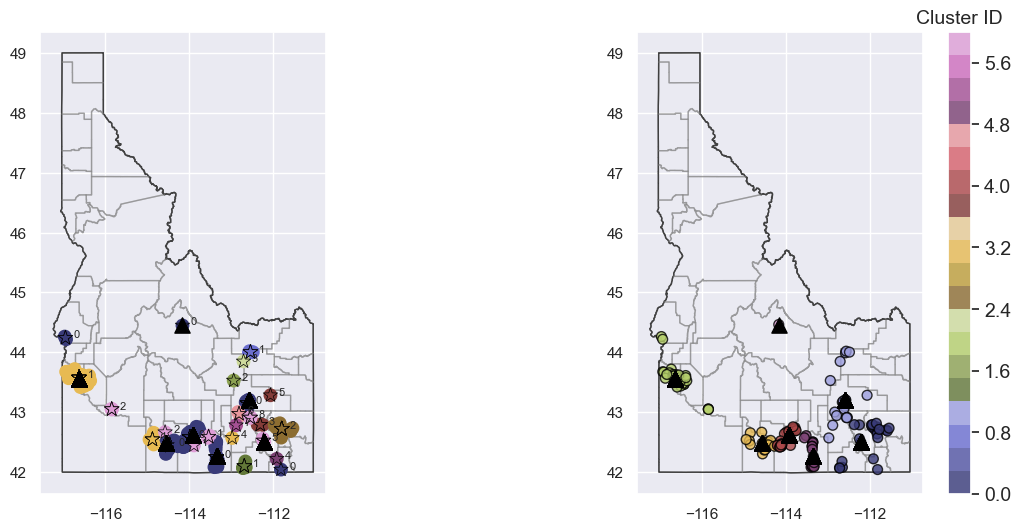

In [ ]:
clustering_maps = plot_well_centroid(bw_cluster_kmeans)

In [ ]:
condensed_subcluster_bw_df = condense_subcluster_table(bw_cluster_kmeans)
condensed_subcluster_bw_df.head(5)

,state_alpha,cluster_id,subcluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,...,well_depth_ft,well_yield,total_well_yield,tds_kgm3,avg_TDS_kgm3,elec_price,well_field_lcow,avg_well_field_lcow,pipe_lcow,avg_subcluster_pipe_lcow
0,ID,0,0,42.498001,-112.2155,1437.84375,42.042278,-111.817864,1385.400269,60.318680,...,[180.0],[0.0252360799999999],0.025236,[0.547],0.547000,0.0608,[0.0462856251944781],0.046286,[0.0],0.000000
1,ID,0,1,42.498001,-112.2155,1437.84375,42.099508,-112.691847,1418.637085,59.145901,...,"[400.0, 331.0, 107.0, 267.0]","[0.17034354, 0.1061808066, 0.03785412, 0.18927...",0.503649,"[0.78, 0.616, 1.02, 1.13]",0.894993,0.0608,"[0.0567588743872114, 0.0529632539265126, 0.040...",0.051424,"[0.07498155439516094, 0.08473797270364505, 0.1...",0.086121
2,ID,0,2,42.498001,-112.2155,1437.84375,42.722640,-111.799636,1689.117554,42.215786,...,"[216.0, 69.0, 250.0, 97.0, 200.0, 207.0, 190.0...","[0.01892706, 0.0504721599999999, 0.0630902, 0....",0.917930,"[0.525, 0.875, 0.684, 1.2297608, 0.662, 0.741,...",0.715799,0.0608,"[0.0494199722797886, 0.0373587533398425, 0.048...",0.043775,"[0.2562115479570355, 0.25452256680326274, 0.25...",0.164593
3,ID,0,3,42.498001,-112.2155,1437.84375,42.790192,-112.311916,1389.559448,33.433525,...,"[175.0, 195.0]","[0.020504315, 0.010725334]",0.031230,"[0.762, 0.5]",0.672020,0.0608,"[0.0466844112523766, 0.0495397547074491]",0.047665,"[0.19921154850249467, 0.29247540447076675]",0.231242
4,ID,0,4,42.498001,-112.2155,1437.84375,42.221867,-111.918289,1485.015381,39.231773,...,[206.0],[0.06939922],0.069399,[0.531],0.531000,0.0608,[0.0454799908344452],0.045480,[0.0],0.000000


In [ ]:
condensed_cluster_bw_df = condense_cluster_table(condensed_subcluster_bw_df)
condensed_cluster_bw_df.head(5)

0 -> 4 -> 5 -> treatment_node
1 -> 5 -> treatment_node
2 -> 5 -> treatment_node
4 -> 5 -> treatment_node
3 -> 5 -> treatment_node
5 -> treatment_node

Node: 0
Nodes included 0

Node: 3
Nodes included 3
Node: 4
Nodes included 4
Nodes included 0
Node: 2
Nodes included 2
Node: 1
Nodes included 1

Node: 5
Nodes included 5
Nodes included 3
Nodes included 4
Nodes included 2
Nodes included 1
1 -> 3 -> 2 -> 0 -> treatment_node
4 -> 7 -> 6 -> 0 -> treatment_node
3 -> 2 -> 0 -> treatment_node
7 -> 6 -> 0 -> treatment_node
2 -> 0 -> treatment_node
5 -> 0 -> treatment_node
8 -> 6 -> 0 -> treatment_node
6 -> 0 -> treatment_node
0 -> treatment_node

Node: 4
Nodes included 4
Node: 1
Nodes included 1

Node: 8
Nodes included 8
Node: 7
Nodes included 7
Nodes included 4
Node: 3
Nodes included 3
Nodes included 1

Node: 6
Nodes included 6
Nodes included 8
Nodes included 7
Node: 5
Nodes included 5
Node: 2
Nodes included 2
Nodes included 3

Node: 0
Nodes included 0
Nodes included 6
Nodes included 5
Nodes inc

,state_alpha,cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,unique_site_ID,cluster_total_well_yield,cluster_avg_TDS_kgm3,elec_price,cluster_avg_well_field_lcow,cluster_avg_pipe_well_subcluster_lcow,cluster_avg_pipe_subcluster_cluster_lcow
0,ID,0,42.498001,-112.215500,1437.843750,"[42.0422783, 42.0995083, 42.722640049999995, 4...","[-111.8178635, -112.69184685, -111.79963620833...","[1385.400268555, 1418.637084961, 1689.11755371...","[60.31867973908891, 59.14590105549539, 42.2157...","USGS-420233111490101,USGS-420423112433301,USGS...",1.672678,0.760498,0.0608,0.046480,0.128141,0.123898
1,ID,1,43.208248,-112.584709,1378.765747,"[43.15040968571429, 44.00453566666666, 43.5287...","[-112.61530302857145, -112.54554493333335, -11...","[1370.396240234, 1462.0880126950003, 1505.0620...","[6.893194234152318, 88.599389598821, 45.971562...","USGS-431200112342201,USGS-431001112392501,USGS...",1.392716,0.663616,0.0608,0.045571,0.081609,0.134325
2,ID,2,43.554195,-116.632553,791.647949,"[44.24030495, 43.577552272727274, 43.050496433...","[-116.952404, -116.62786900454545, -115.849192...","[642.87701416, 750.9360961910002, 916.392150879]","[80.48132762692062, 2.624446133643896, 84.5887...","USGS-441547116580001,USGS-441304116561401,USGS...",1.795557,0.630194,0.0608,0.049641,0.180935,0.116156
3,ID,3,42.479912,-114.568100,1281.121338,"[42.44217577272727, 42.54580405, 42.6660194]","[-114.46177119090908, -114.8798256, -114.5781021]","[1315.193481445, 1173.815673828, 1077.310791016]","[9.679245691674971, 26.5802751499012, 20.71045...","USGS-422837114282501,USGS-422653114261801,USGS...",0.895692,0.681703,0.0608,0.073304,0.135578,0.107967
4,ID,4,42.619633,-113.916412,1277.655273,"[42.583957272413805, 42.4454651]","[-113.98199962413793, -113.8911285]","[1281.274291992, 1314.646606445]","[6.674874289936064, 19.477076457073494]","USGS-422542114062701,USGS-424328113484001,USGS...",3.345290,0.629791,0.0608,0.053444,0.164504,0.052664


In [ ]:
# The LCOW have a corrected basis
condensed_cluster_bw_df = calc_cluster_lcow(condensed_cluster_bw_df,dist_to_dwi = 16.0934)
condensed_cluster_bw_df.head(5)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

,state_alpha,cluster_id,centroid_lat,centroid_long,centroid_elev,subcluster_lat,subcluster_long,subcluster_elev,subcluster_centroid_dist,unique_site_ID,cluster_total_well_yield,cluster_avg_TDS_kgm3,elec_price,cluster_avg_well_field_lcow,cluster_avg_pipe_well_subcluster_lcow,cluster_avg_pipe_subcluster_cluster_lcow,treatment_lcow,cluster_pipe_brine_lcow,recovery,cluster_lcow
0,ID,0,42.498001,-112.215500,1437.843750,"[42.0422783, 42.0995083, 42.722640049999995, 4...","[-111.8178635, -112.69184685, -111.79963620833...","[1385.400268555, 1418.637084961, 1689.11755371...","[60.31867973908891, 59.14590105549539, 42.2157...","USGS-420233111490101,USGS-420423112433301,USGS...",1.672678,0.760498,0.0608,0.050009,0.137868,0.133303,0.504931,0.014407,91.514000,0.840519
1,ID,1,43.208248,-112.584709,1378.765747,"[43.15040968571429, 44.00453566666666, 43.5287...","[-112.61530302857145, -112.54554493333335, -11...","[1370.396240234, 1462.0880126950003, 1505.0620...","[6.893194234152318, 88.599389598821, 45.971562...","USGS-431200112342201,USGS-431001112392501,USGS...",1.392716,0.663616,0.0608,0.049031,0.087805,0.144523,0.506508,0.015187,91.818826,0.803053
2,ID,2,43.554195,-116.632553,791.647949,"[44.24030495, 43.577552272727274, 43.050496433...","[-116.952404, -116.62786900454545, -115.849192...","[642.87701416, 750.9360961910002, 916.392150879]","[80.48132762692062, 2.624446133643896, 84.5887...","USGS-441547116580001,USGS-441304116561401,USGS...",1.795557,0.630194,0.0608,0.053410,0.194671,0.124974,0.497921,0.013613,91.844037,0.884589
3,ID,3,42.479912,-114.568100,1281.121338,"[42.44217577272727, 42.54580405, 42.6660194]","[-114.46177119090908, -114.8798256, -114.5781021]","[1315.193481445, 1173.815673828, 1077.310791016]","[9.679245691674971, 26.5802751499012, 20.71045...","USGS-422837114282501,USGS-422653114261801,USGS...",0.895692,0.681703,0.0608,0.078869,0.145871,0.116164,0.521981,0.018386,91.894204,0.881271
4,ID,4,42.619633,-113.916412,1277.655273,"[42.583957272413805, 42.4454651]","[-113.98199962413793, -113.8911285]","[1281.274291992, 1314.646606445]","[6.674874289936064, 19.477076457073494]","USGS-422542114062701,USGS-424328113484001,USGS...",3.345290,0.629791,0.0608,0.057501,0.176993,0.056662,0.483150,0.010818,91.691229,0.785124


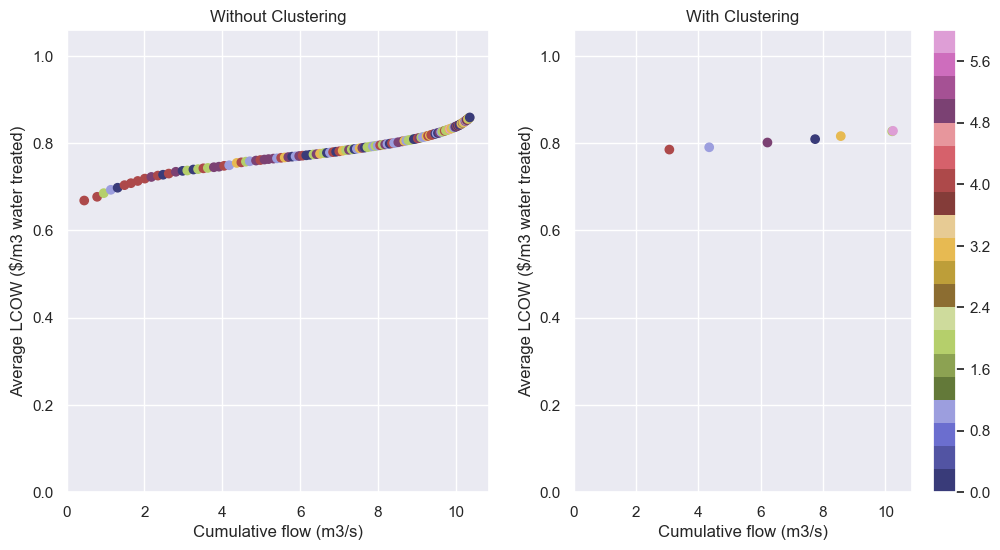

In [ ]:
supply_curve = plot_supply_curve(bw_cluster_kmeans,condensed_cluster_bw_df,state_alpha)

In [ ]:
# Saving Results

# Check if folder already exists
PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha
if not os.path.exists(PATH):
    os.makedirs(PATH)

bw_cluster_kmeans.to_csv(PATH + '\\' + state_alpha.lower()+'_bw_kmeans.csv')    
condensed_subcluster_bw_df.to_csv(PATH + '\\' + state_alpha.lower()+'_subcluster.csv')
condensed_cluster_bw_df.to_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv')
supply_curve.savefig(PATH + '\\' + state_alpha.lower()+'_supply_curve.jpg')
clustering_maps.savefig(PATH + '\\' + state_alpha.lower()+'_clustering.jpg')

Below is rough work which was consolidated into bw_lcow_functions.py

In [ ]:
# Plot supply curve with and without clustering
# fig, (ax,ax1) = plt.subplots(1,2, figsize = (12,6))

# # Without clustering
# bw_df_temp_sorted_1 = bw_df[bw_df['state_alpha']==state_alpha].sort_values('lcow')
# colors = plt.cm.get_cmap('tab20b')
# cluster_id_list = []
# for well in bw_df_temp_sorted_1['unique_site_ID'].unique():
#     cluster_id_list.append(bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==well]['cluster_id'].values[0])

# # Calculating LCOW as a function of well yield without clustering
# flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
# cum_flow_1 = flow.cumsum()

# lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
# cost = lcow_t*flow
# cum_cost_1 = cost.cumsum()

# avg_lcow = np.divide(cum_cost_1, cum_flow_1, out=np.zeros_like(cum_cost_1), where=cum_flow_1!=0) 

# ax.scatter(cum_flow_1,avg_lcow,c = cluster_id_list,cmap=colors)
# ax.set_title('Without Clustering')

# # With clustering
# condensed_cluster_bw_df_sort = condensed_cluster_bw_df.sort_values(by=['cluster_lcow'])

# flow = condensed_cluster_bw_df_sort['cluster_total_well_yield']*condensed_cluster_bw_df_sort['recovery']/100
# cum_flow = flow.cumsum()

# cost = condensed_cluster_bw_df_sort['cluster_lcow']*flow
# cum_cost = cost.cumsum()

# avg_lcow = np.divide(cum_cost, cum_flow) 

# ax1.set_title('With Clustering')
# sc = ax1.scatter(cum_flow,avg_lcow,c=condensed_cluster_bw_df_sort['cluster_id'].values,cmap=colors)
# # cbar = plt.colorbar(sc,ax=ax1)
# cbar = plt.colorbar(sc,ax=ax1,ticks = plt.MaxNLocator(len(condensed_cluster_bw_df_sort['cluster_id'].unique())-1))
# for a in (ax,ax1):
#     a.set_xlim([0,max(cum_flow_1)+0.5])
#     a.set_ylim([0,max(avg_lcow)+0.2])
#     a.set_ylabel('Average LCOW ($/m3 water treated)')
#     a.set_xlabel('Cumulative flow (m3/s)')

# print(max(avg_lcow))

In [ ]:
# Read brackish water previous lcow file with locations

# bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
# pp_combined_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\MSD Workshop\data\pp_df.csv').drop(['Unnamed: 0'],axis=1)
# loc = [Point(xy) for xy in zip(pp_combined_df['PPLongitude'],pp_combined_df['PPLatitude'])]
# loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
# pp_combined_df['geometry'] = loc

In [ ]:
# Function to form clusters

# def form_cluster(df,n_clusters = 3):
#     kmeans = KMeans(n_clusters = n_clusters, init ='k-means++',random_state=42)
#     kmeans.fit(df[df.columns[2:4]])  # Compute k-means clustering.
#     df['cluster_id'] = kmeans.fit_predict(df[df.columns[2:4]])
#     centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
#     labels = kmeans.predict(df[df.columns[2:4]])  # Labels of each point
#     centers_array = []
#     for idx,row in df.iterrows():
#         centers_array.append(centers[int(row['cluster_id'])])
#     df['centers'] = centers_array
    
#     return df

In [ ]:
# Create a table with cluster ID

# bw_cluster_kmeans = pd.DataFrame()
# bw_state_df = pd.DataFrame()
# bw_state_df_loc = pd.DataFrame()

# for state in ['CT']: #bw_df['state_alpha'].unique():
#     # kmeans doesn't work for fewer than 3 points. Calculate centroid for these cases
#     print('State:',state)
#     bw_state_df = bw_df[bw_df['state_alpha'] == state].copy()
#     bw_state_df_loc = bw_state_df[['state_alpha','unique_site_ID','Latitude','Longitude','county_nm','well_depth_ft','well_yield','TDS_kgm3','elec_price','well_field_lcow']]

#     if len(bw_state_df)<=3:
#         bw_state_df_loc['cluster_id'] = 0
#         bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
#         bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,bw_state_df_loc])
#         continue 

#     # First pass at clustering for a state
#     # bw_state_df_loc = bw_state_df[['unique_site_ID','Latitude','Longitude']].copy()
#     bw_state_df_loc = form_cluster(bw_state_df_loc)

#     # Assign well yield
#     bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
#     bw_state_df_loc = bw_state_df_loc.sort_values(['cluster_id'])

#     # print('Initial cluster list:',bw_state_df_loc['cluster_id'].unique())

#     # To keep track of clusters and new created clusters if the maximum capacity of a treatment plant is exceeded
#     prev_max_cluster_label = 0

#     # Dataframe for each state with their respective cluster id
#     cluster_state_df = pd.DataFrame()

#     for cluster_id in bw_state_df_loc['cluster_id'].unique():
#         cluster_sub_df = pd.DataFrame()
#         temp_df = pd.DataFrame()
#         # Check if maximum capacity of treatment plant is exceeded
#         well_yield_total = sum(bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id]['well_yield'])

#         max_capacity = math.ceil(27.5*0.043813)  #---> Number is based on Carlsbad. Kay Bailey is 27.5 MGD
#         if well_yield_total > max_capacity: 
#             # If exceed increase number of clusters in the original cluster and redo
            
#             cluster_sub_df = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()

#             # print("Number of clusters required:", math.ceil(well_yield_total/max_capacity))
#             temp_df = form_cluster( cluster_sub_df, n_clusters = math.ceil(well_yield_total/max_capacity))
#             temp_df = temp_df.sort_values(['cluster_id'])
#             if cluster_id == 0:
#                 temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'])
#             else:
#                 temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'] + 1)
#             prev_max_cluster_label = max(temp_df['cluster_id'])
            
#             cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
#         else:
#             # If maximum capacity is not exceeded add to state data frame
#             temp_bw_state_df_loc = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()
#             if cluster_id == 0:
#                temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label 
#             else:
#                temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label + 1

#             cluster_state_df = pd.concat([cluster_state_df,temp_bw_state_df_loc],ignore_index=True)
#             prev_max_cluster_label = max(cluster_state_df['cluster_id'])

#         print(cluster_state_df['cluster_id'].unique())
    
#     bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,cluster_state_df])

In [ ]:
# Function to find well closest to the center of the cluster
# def select_centroid(df):
#     max_dist = 1000
#     # well = df['unique_site_ID'][0]

#     for idx, row in df.iterrows():
#         bw_long = row['Longitude']
#         bw_lat = row['Latitude']

#         bw_loc = (bw_lat,bw_long)

#         cent_long = row['centers'][1]
#         cent_lat = row['centers'][0]
        
#         cent_loc = (cent_lat,cent_long)

#         dist_km = hs.haversine(cent_loc,bw_loc)

#         if dist_km < max_dist:
#             max_dist = dist_km
#             well = row['unique_site_ID']
    
#     return well
        

In [ ]:
# Create subclusters to calculate pipe transport costs

# def find_centroid(coords,cluster_range = 5):
#     kms_per_radian = 6371.0088
#     range_km = cluster_range*1.609343502101154
#     epsilon = range_km/ kms_per_radian

#     db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
#     cluster_labels = db.labels_

#     # get the number of clusters
#     num_clusters = len(set(cluster_labels))

#     # turn the clusters in to a pandas series, where each element is a cluster of points
#     clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
#     centroids = []

#     for ea in clusters:
#         centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

#     centroids = np.array(centroids)
#     return [centroids,cluster_labels]

# def create_subcluster(state_df):
#     sub_cluster_df = pd.DataFrame(columns = ['sub_cluster_id','centroid'])

#     for cluster_id in state_df['cluster_id'].unique():
        
#         coords_input = state_df[state_df['cluster_id']==cluster_id][['Latitude', 'Longitude']].to_numpy()
#         centroids,cluster_labels = find_centroid(coords_input,10)

#         loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
#         loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
#         loc.geometry = loc.geometry.to_crs('EPSG:4326')

#         # Assign cluster label
#         temp = pd.DataFrame(columns = ['sub_cluster_id','centroid'])
#         # temp['cluster_id'] = 0
#         temp['sub_cluster_id'] = cluster_labels
#         temp['centroid'] = loc.geometry[cluster_labels].values

#         sub_cluster_df= pd.concat([sub_cluster_df,temp])

#     return [sub_cluster_df['sub_cluster_id'].values.tolist(), 
#             sub_cluster_df['centroid'].values.x.tolist(), 
#             sub_cluster_df['centroid'].values.y.tolist()]

# Groups wells within 25 miles of each other

In [ ]:
# Assign elevation to each well field, calculate distance between cluster center and other well fields in the cluster

# well_elevation_list = []
# centroid_elevation_list = []
# subcluster_elevation_list = []

# centroid_long_list = []
# centroid_lat_list = []
# sub_cluster_id_list = []
# sub_cluster_centroid_long_list = []
# sub_cluster_centroid_lat_list = []
# sub_cluster_dist_list = []

# for state in bw_cluster_kmeans.state_alpha.unique():
#     temp_state = bw_cluster_kmeans[bw_cluster_kmeans.state_alpha == state].copy()

#     for cluster_id in temp_state.cluster_id.unique():
#         temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
#         centroid_well = select_centroid(temp_cluster)
#         # print(centroid_well)

#         centroid_long = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Longitude'].values[0]
#         centroid_lat = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Latitude'].values[0]

#         [sub_cluster_id,sub_cluster_centroid_long,sub_cluster_centroid_lat] = create_subcluster(temp_state)

#         for well in temp_cluster['unique_site_ID'].unique():
#             bw_long = temp_cluster[temp_cluster['unique_site_ID']==well]['Longitude'].values[0]
#             bw_lat = temp_cluster[temp_cluster['unique_site_ID']==well]['Latitude'].values[0]

#             well_elevation_list.append(elevation(bw_lat,bw_long))
#             centroid_long_list.append(centroid_long)
#             centroid_lat_list.append(centroid_lat) 
#             centroid_elevation_list.append(elevation(centroid_lat,centroid_long))

#     sub_cluster_id_list.extend(sub_cluster_id)
#     sub_cluster_centroid_long_list.extend(sub_cluster_centroid_long)
#     sub_cluster_centroid_lat_list.extend(sub_cluster_centroid_lat)

# bw_cluster_kmeans['well_elevation'] = well_elevation_list
# bw_cluster_kmeans['centroid_long'] = centroid_long_list
# bw_cluster_kmeans['centroid_lat'] = centroid_lat_list
# bw_cluster_kmeans['centroid_elevation'] = centroid_elevation_list
# bw_cluster_kmeans['sub_cluster_id'] = sub_cluster_id_list
# bw_cluster_kmeans['sub_cluster_long'] = sub_cluster_centroid_long_list
# bw_cluster_kmeans['sub_cluster_lat'] = sub_cluster_centroid_lat_list

# Add distance between sub-cluster centroid and cluster centroid

# for idx, row in bw_cluster_kmeans.iterrows():
#     sub_cluster_loc = (row['sub_cluster_lat'],row['sub_cluster_long'])
#     cent_loc = (row['centroid_lat'],row['centroid_long'])

#     dist_km = hs.haversine(cent_loc,sub_cluster_loc)
#     sub_cluster_dist_list.append(dist_km)

#     subcluster_elevation_list.append(elevation(row['sub_cluster_lat'],row['sub_cluster_long']))

# bw_cluster_kmeans['sub_cluster_to centroid_dist_km'] = sub_cluster_dist_list
# bw_cluster_kmeans['subcluster_elevation'] = subcluster_elevation_list

# bw_cluster_kmeans.head(20)

In [ ]:
# Add cost of pipe transport from well to the subcluster centroid
# pipe_lcow_well_subcluster_list = []

# for idx, row in bw_cluster_kmeans.iterrows():

#     # Distance between subcluster centroid and well
#     sub_cluster_loc = (row['sub_cluster_lat'],row['sub_cluster_long'])
#     well_loc = (row['Latitude'],row['Longitude'])
#     dist_km_well = hs.haversine(well_loc,sub_cluster_loc)

#     # Elevation gain between subcluster centroid and well
#     elev_gain = row['well_elevation'] - row['subcluster_elevation']

#     if elev_gain<0:
#         elev_gain = 1e-5    

#     pipe_lcow_well_subcluster = pipe_costing(row['well_yield']*3600*24, dist_km_well,
#                                              elev_gain=elev_gain,electricity_rate=row['elec_price'])
    
#     pipe_lcow_well_subcluster_list.append(pipe_lcow_well_subcluster)

# bw_cluster_kmeans['pipe_lcow_well_subcluster'] = pipe_lcow_well_subcluster_list


In [ ]:
# Condense to subcluster level
# calc_avg_tds = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])
# calc_well_field_lcow = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])
# calc_pipe_lcow = lambda x: np.average(x, weights=bw_cluster_kmeans.loc[x.index, "well_yield"])

# cluster_df = pd.DataFrame()

# Condense to cluster level
# for state in bw_cluster_kmeans['state_alpha'].unique():
#     temp_df = bw_cluster_kmeans[bw_cluster_kmeans['state_alpha']==state]
#     for cluster in temp_df['cluster_id'].unique():
#         temp_cluster_df = temp_df[temp_df['cluster_id']==cluster]

#         group_table  = temp_cluster_df.groupby(['state_alpha','cluster_id','sub_cluster_id']).agg(
#                 centroid_lat = ('centroid_lat','mean'),
#                 centroid_long = ('centroid_long','mean'),
#                 centroid_elev = ('centroid_elevation','mean'),

#                 subcluster_lat = ('sub_cluster_lat','mean'),
#                 subcluster_long = ('sub_cluster_long','mean'),
#                 subcluster_elev = ('subcluster_elevation','mean'),
#                 subcluster_centroid_dist = ('sub_cluster_to centroid_dist_km','mean'),

#                 unique_site_ID = ('unique_site_ID',','.join),
#                 well_lat = ('Latitude', pd.Series.to_list),
#                 well_long = ('Longitude',pd.Series.to_list),
#                 county_nm = ('county_nm',pd.Series.to_list),
#                 well_elevation = ('well_elevation',pd.Series.to_list),
#                 well_depth_ft = ('well_depth_ft', pd.Series.to_list),
#                 well_yield = ('well_yield',pd.Series.to_list),
#                 total_well_yield = ('well_yield','sum'),
#                 tds_kgm3 = ('TDS_kgm3',pd.Series.to_list),
#                 avg_TDS_kgm3 = ('TDS_kgm3', calc_avg_tds),
#                 elec_price = ('elec_price','mean'),
#                 well_field_lcow = ('well_field_lcow',pd.Series.to_list),
#                 avg_well_field_lcow = ('well_field_lcow',calc_well_field_lcow),
#                 pipe_lcow = ('pipe_lcow_well_subcluster', pd.Series.to_list),
#                 avg_subcluster_pipe_lcow = ('pipe_lcow_well_subcluster', calc_pipe_lcow),

#                ).reset_index()

#         cluster_df = pd.concat((cluster_df,group_table))
# cluster_df.reset_index(inplace=True)
# cluster_df.head(10)
# check


In [ ]:
# Condense to cluster level
# Inline functions to calculate weighted average tds and lcows
# calc_avg_tds = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])
# calc_well_field_lcow = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])
# calc_pipe_lcow = lambda x: np.average(x, weights=cluster_df.loc[x.index, "total_well_yield"])

# cluster_bw_df = pd.DataFrame()
# # Condense the table further to the cluster level
# for cluster in cluster_df['cluster_id'].unique():
#     temp_df = cluster_df[cluster_df['cluster_id'] == cluster]

#     group_table  = temp_df.groupby(['state_alpha','cluster_id']).agg(
#             centroid_lat = ('centroid_lat','mean'),
#             centroid_long = ('centroid_long','mean'),
#             centroid_elev = ('centroid_elev','mean'),

#             subcluster_lat = ('subcluster_lat',pd.Series.to_list),
#             subcluster_long = ('subcluster_long',pd.Series.to_list),
#             subcluster_elev = ('subcluster_elev',pd.Series.to_list),
#             subcluster_centroid_dist = ('subcluster_centroid_dist',pd.Series.to_list),

#             cluster_total_well_yield = ('total_well_yield','sum'),
#             cluster_avg_TDS_kgm3 = ('avg_TDS_kgm3', calc_avg_tds),
#             elec_price = ('elec_price','mean'),
#             cluster_avg_well_field_lcow = ('avg_well_field_lcow',calc_well_field_lcow),
#             cluster_avg_pipe_lcow = ('avg_subcluster_pipe_lcow', calc_pipe_lcow),

#         ).reset_index()

#     cluster_bw_df = pd.concat((cluster_bw_df,group_table))

# cluster_bw_df

In [ ]:
# pipe_lcow_subcluster_centroid_list = []
# for cluster in cluster_df['cluster_id'].unique()[0:1]:
#     temp_df = cluster_df[cluster_df['cluster_id'] == cluster]
#     for subcluster in temp_df['sub_cluster_id'].unique()[0:1]:
#         print(temp_df[temp_df['sub_cluster_id']==subcluster]['subcluster_centroid_dist'].values[0])
#         print(temp_df[temp_df['sub_cluster_id']==subcluster]['subcluster_elev'].values[0])
#         print(temp_df[temp_df['sub_cluster_id']==subcluster]['centroid_elev'].values[0])
#         print(temp_df[temp_df['sub_cluster_id']==subcluster]['total_well_yield'].values[0])
#         pipe_costing()

In [ ]:
# bw_cluster_kmeans.to_csv(r'\Users\mhardika\Documents\AMO\ct_kmeans_28Nov23.csv')

In [ ]:
# Sort data in decreasing order of well yield
# bw_cluster_kmeans_sorted = bw_cluster_kmeans.sort_values(['state_alpha','cluster_id','well_yield'],
#                                                          ascending=[True,True,False]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
# bw_cluster_kmeans_sorted.reset_index(inplace=True,drop=True)
# bw_cluster_kmeans_sorted.head(2)

In [ ]:
# temp_state =  bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == 'WI']
# temp_cluster = temp_state[temp_state.cluster_id==0]
# centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]

# temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]


In [ ]:
# Function to calculate LCOW

# def treatment_only_LCOW(capacity,tds, well_depth, elec_price):
#     case_study = 'big_spring'
#     scenario = 'dwi_a'
#     desired_recovery = 1
#     ro_bounds = 'other' # or 'seawater'

#     m = watertap_setup(case_study=case_study, scenario=scenario)
#     m = get_case_study(m=m)
#     m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

#     m.fs.reverse_osmosis.membrane_area.unfix()
#     m.fs.reverse_osmosis.feed.pressure.unfix()

#     m.fs.big_spring_feed.flow_vol_in.fix(capacity) # capacity in m3s
#     m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(tds) # tds in kg/m3
#     m.fs.well_field.lift_height.fix(well_depth)

#     m.fs.costing_param.electricity_price = elec_price 
#     m = run_and_return_model(m, objective=True,print_it=True)
#     m, df = get_results_table(m=m, case_study='test', scenario=scenario)    
#     lcow = m.fs.costing.LCOW.value()
#     well_field_lcow = m.fs.well_field.LCOW()
#     recovery = m.fs.costing.system_recovery()*100
#     # clear_output(wait=True)
#     # print(well_field_lcow)
#     # Exclude the well field LCOW from the cost ($/m3 avg well field flow), well lcow ($/m3 of only that well) and brine volume in m3/day
#     return (lcow-well_field_lcow,recovery, m.fs.deep_well_injection.flow_vol_in[0].value*3600*24)

# treatment_only_LCOW(0.277597,1.760000,1975,0.0545)

In [ ]:
# Calculate cumulative well yield, cumulative tds, lcow without well field, pipe lcow to treatment, brine lcow
# bw_cluster_lcow = bw_cluster_kmeans_sorted.copy()

# avg_well_yield_list = []
# avg_tds_list = []
# treatment_lcow_list = []
# recovery_list = []
# brine_vol_list = []
# pipe_lcow_list = []
# brine_lcow_list = []

# dist_to_dwi = 16.0934 # = 10 miles

# for state in bw_cluster_kmeans_sorted.state_alpha.unique():
#     temp_state = bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == state].copy()
    
#     for cluster_id in temp_state.cluster_id.unique():
#         temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
#         avg_well_yield = 0
#         avg_tds = 0
        
#         centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]
#         centroid_elev = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]
#         print(centroid_elev)

#         for well in temp_cluster['unique_site_ID'].unique():
#             # Calculate average well yield
#             avg_well_yield_old = avg_well_yield
#             avg_well_yield = avg_well_yield + temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0]

#             # Calculate average TDS
#             avg_tds = ((avg_tds*avg_well_yield_old 
#                        + temp_cluster[temp_cluster['unique_site_ID']==well]['TDS_kgm3'].values[0] *temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0])
#                         /avg_well_yield)
            
#             avg_well_yield_list.append(avg_well_yield)
#             avg_tds_list.append(avg_tds)

#             treatment_lcow, recovery, brine_flow = treatment_only_LCOW(avg_well_yield, avg_tds, 
#                                                                   temp_cluster[temp_cluster['unique_site_ID']==well]['well_depth_ft'].values[0],
#                                                                   temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
            
#             treatment_lcow_list.append(treatment_lcow)
#             recovery_list.append(recovery)
#             brine_vol_list.append(brine_flow)

#             elev_gain = centroid_elev - temp_cluster['well_elevation'].values[0] 

#             if elev_gain <= 0:
#                 elev_gain = 1e-5
#             pipe_lcow = pipe_costing(avg_well_yield*3600*24, temp_cluster[temp_cluster['unique_site_ID']==well]['dist_km'].values[0], elev_gain = elev_gain,
#                                       electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])/(recovery/100)

#             pipe_lcow_list.append(pipe_lcow)

#             brine_transport_lcow = (pipe_costing(brine_flow, dist_to_dwi, elev_gain = 1e-5, 
#                                                  electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
#                                         *(100-recovery)/recovery)
            
#             brine_lcow_list.append(brine_transport_lcow)
            
# bw_cluster_lcow['avg_well_yield_m3/s'] = avg_well_yield_list
# bw_cluster_lcow['avg_tds'] = avg_tds_list
# bw_cluster_lcow['treatment_lcow'] = treatment_lcow_list
# bw_cluster_lcow['recovery'] = recovery_list
# bw_cluster_lcow['brine_vol_m3/day'] = brine_vol_list
# bw_cluster_lcow['pipe_to_treatment_lcow'] = pipe_lcow_list
# bw_cluster_lcow['brine_dwi_lcow'] = brine_lcow_list

# bw_cluster_lcow.head(3)

In [ ]:
# bw_cluster_lcow['cluster_lcow'] = bw_cluster_lcow['treatment_lcow'] + \
#                 bw_cluster_lcow['well_field_lcow']*bw_cluster_lcow['well_yield']/(bw_cluster_lcow['avg_well_yield_m3/s']*bw_cluster_lcow['recovery']/100) + \
#                 bw_cluster_lcow['brine_dwi_lcow'] +\
#                 bw_cluster_lcow['pipe_to_treatment_lcow']

In [ ]:
# bw_cluster_lcow_sorted = bw_cluster_lcow.sort_values(['state_alpha','cluster_id','cluster_lcow'],ascending=[True,True,True]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
# bw_cluster_lcow_sorted.reset_index(inplace=True,drop=True)
# bw_cluster_lcow.head(6)

In [ ]:
# bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\tx_kmeans_lcow_8Nov23.csv')

In [ ]:
# fig, ax = plt.subplots()

# state_cluster_lcow = bw_cluster_lcow_sorted[bw_cluster_lcow_sorted['state_alpha']=='WI']

# for cluster in state_cluster_lcow['cluster_id'].unique():
#     temp = state_cluster_lcow[state_cluster_lcow['cluster_id']==cluster]
#     ax.scatter(temp['avg_well_yield_m3/s'].cumsum(),temp['cluster_lcow'],label = cluster)

# ax.legend()

In [ ]:
# bw_df_temp_sorted_1 = bw_df[bw_df['state_alpha']=='WI'].sort_values('lcow')

# lcow = 0
# total_water = 0

# fig, ax = plt.subplots()

# # Calculating LCOW as a function of well yield without clustering
# flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
# cum_flow = flow.cumsum()

# lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
# cost = lcow_t*flow
# cum_cost = cost.cumsum()

# avg_lcow = np.divide(cum_cost, cum_flow, out=np.zeros_like(cum_cost), where=cum_flow!=0) 

# ax.scatter(cum_flow,avg_lcow)
# ax.set_xlim([0,2])

In [ ]:
# wacc = 0.05
# plant_lifetime_yrs =30
# capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
# capital_recovery_factor